In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

# Imports

In [3]:
import configparser

import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib

# Dataset

## Dataset in a pandas Dataframe

In [4]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [5]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [6]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', 'FreeHandV4')
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [7]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [8]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [9]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [10]:
model = neural_networks.freehand_v4(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64, 16)         64        
_________________________________________________________________
dense (Dense)                (None, 1, 64, 256)        4352  

### Train the model

In [11]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100
162/162 [==============================] - 19s 32ms/step - loss: 1.9139 - val_loss: 3.6068
Epoch 2/100
162/162 [==============================] - 4s 27ms/step - loss: 1.3549 - val_loss: 3.8584
Epoch 3/100
162/162 [==============================] - 4s 27ms/step - loss: 1.2780 - val_loss: 2.5493
Epoch 4/100
162/162 [==============================] - 4s 27ms/step - loss: 1.2437 - val_loss: 3.0037
Epoch 5/100
162/162 [==============================] - 4s 27ms/step - loss: 1.2231 - val_loss: 1.2296
Epoch 6/100
162/162 [==============================] - 4s 27ms/step - loss: 1.2026 - val_loss: 1.2076
Epoch 7/100
162/162 [==============================] - 4s 27ms/step - loss: 1.1856 - val_loss: 1.2091
Epoch 8/100
162/162 [==============================] - 4s 27ms/step - loss: 1.1736 - val_loss: 1.1715
Epoch 9/100
162/162 [==============================] - 4s 27ms/step - loss: 1.1621 - val_loss: 1.1702
Epoch 10/100
162/162 [==============================] - 4s 27ms/step - loss: 1.15

# Evaluate and Plot Model Performance

In [12]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

54/54 [==============================] - 0s 9ms/step - loss: 1.1465
1.1464576721191406


## Loss

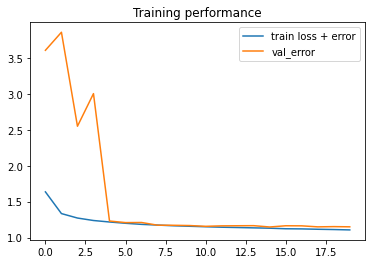

In [13]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

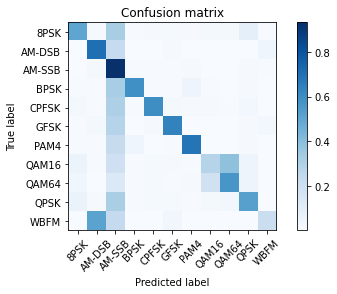

In [14]:
evaluationlib.plot_confusion_matrix(model, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08841010401188708
Overall Accuracy:  0.09426987060998152
Overall Accuracy:  0.09614704842700601
Overall Accuracy:  0.12333099086437105
Overall Accuracy:  0.15426300578034682
Overall Accuracy:  0.24024346580737557
Overall Accuracy:  0.3554281619491222
Overall Accuracy:  0.4934593023255814
Overall Accuracy:  0.6180333688320909
Overall Accuracy:  0.7235801581595974
Overall Accuracy:  0.7959331880900509
Overall Accuracy:  0.8337540569780022
Overall Accuracy:  0.8409867172675521
Overall Accuracy:  0.841044776119403
Overall Accuracy:  0.8476224783861671
Overall Accuracy:  0.8501640539555232
Overall Accuracy:  0.8407997038134024
Overall Accuracy:  0.8394133132756676
Overall Accuracy:  0.8522476050110538
Overall Accuracy:  0.8469534050179212


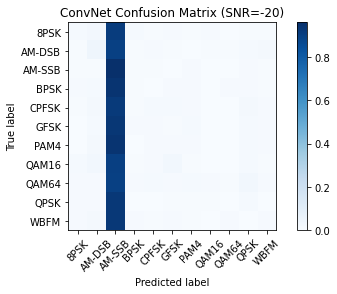

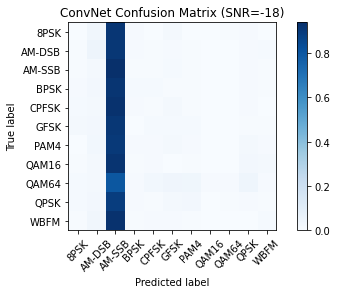

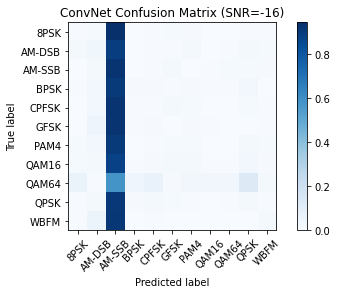

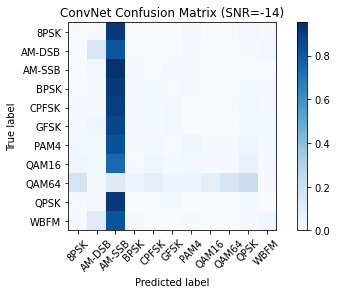

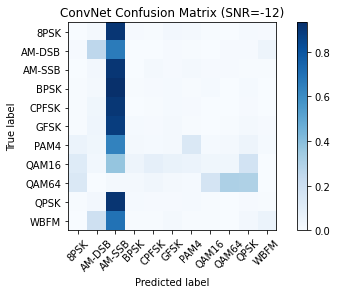

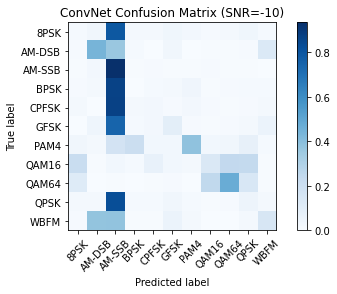

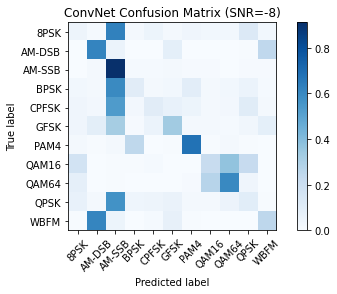

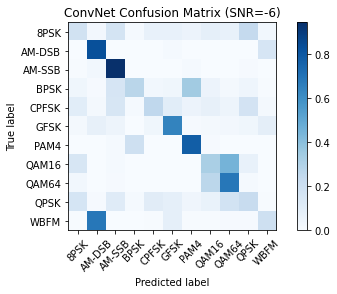

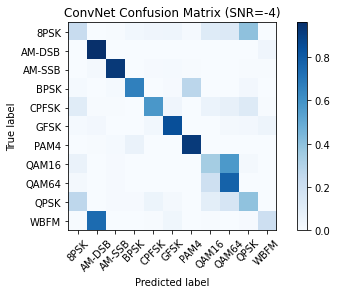

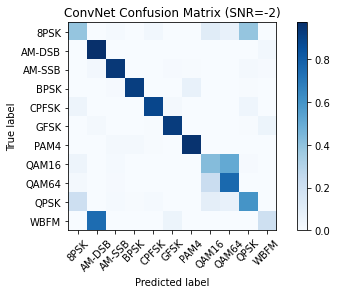

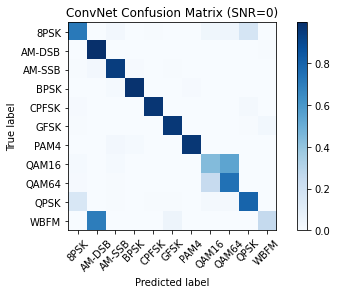

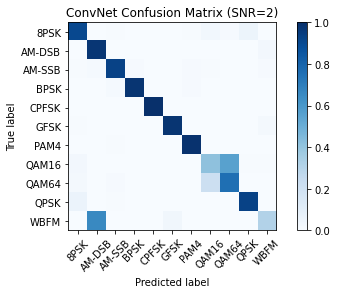

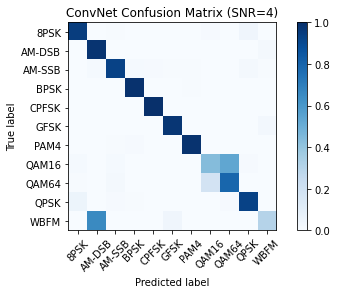

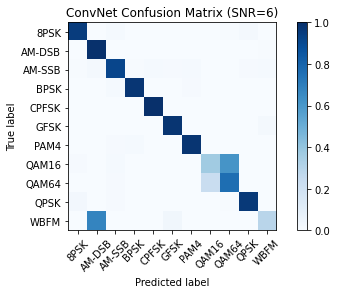

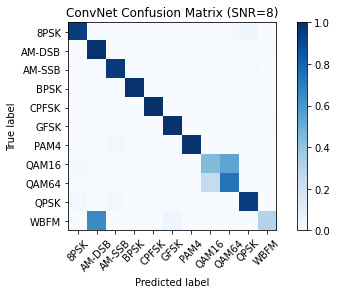

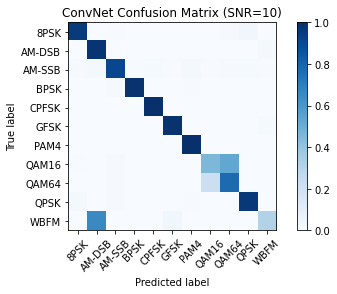

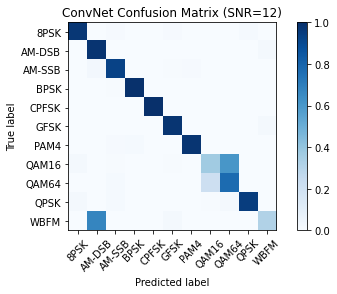

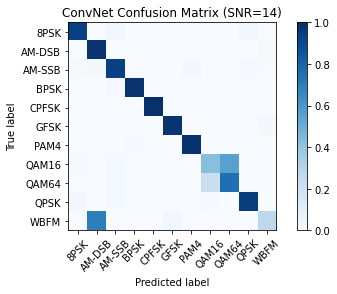

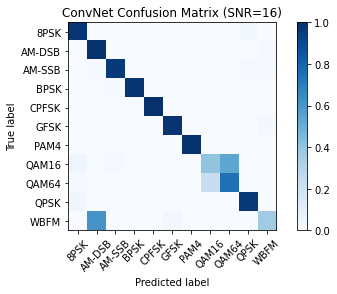

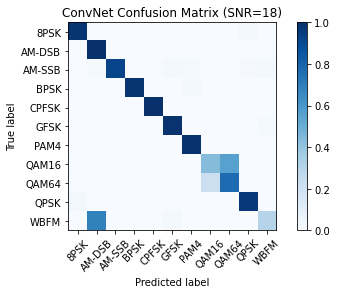

In [15]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [16]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,12,15,24,35,49,61,72,79,83,84,84,84,85,84,83,85,84


In [17]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

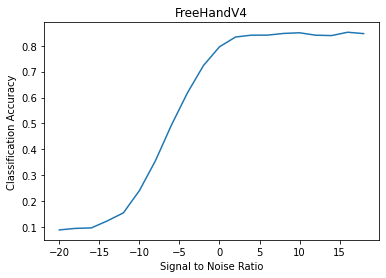

In [18]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)